## Note:
this is a workbook notebook for testing the baseline, lstm and cnn model... the final notebook will have much more examples and will have visualization on how the data looks

In [2]:
%matplotlib inline
# General imports
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import random
from collections import Counter, defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt


#keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom functions
%load_ext autoreload
%autoreload 2
import database_selection
import vectorization
import helpers
import icd9_cnn_model
import lstm_model


Using TensorFlow backend.


In [3]:
#reading file
full_df = pd.read_csv('../data/disch_notes_all_icd9.csv',
                 names = ['HADM_ID', 'SUBJECT_ID', 'DATE', 'ICD9','TEXT'])


In [4]:
full_df.shape

(52696, 5)

In [5]:
# taking just a subset of the records for developing models
df = full_df.sample(frac=0.1).reset_index(drop=True)
print df.shape
df.head(10)

(5270, 5)


,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,186489,22963,2183-09-29 00:00:00,5715 45620 042 07070 30551 2848 30590 5723 274...,Admission Date: [**2183-9-23**] ...
1,185931,19061,2147-03-23 00:00:00,5761 57451 5720 2765 53290 42789,Admission Date: [**2147-3-16**] Dischar...
2,196096,93366,2150-09-17 00:00:00,8028 29181 30421 30301 29680 3102 8020,Admission Date: [**2150-9-14**] ...
3,181494,3242,2163-01-03 00:00:00,4241 42731 4019 2724 4168,Admission Date: [**2162-12-21**] ...
4,108480,94307,2160-11-06 00:00:00,85202 80701 86500 81000 25000 2720 4019 2355,Admission Date: [**2160-11-3**] ...
5,175403,30608,2134-06-12 00:00:00,51884 5849 49121 7455 2763 42832 4280 32723 32...,Admission Date: [**2134-6-7**] D...
6,162078,1663,2141-04-07 00:00:00,1977 99811 1985 1983 1970 1972 1987 1968 185 2...,Admission Date: [**2141-4-1**] D...
7,146759,67683,2164-08-13 00:00:00,42731 45829 41400 412 4019 2449 71690 57420,Admission Date: [**2164-8-11**] ...
8,199210,14089,2179-06-08 00:00:00,85222 85102 30500 4019,Admission Date: [**2179-5-30**] Discharge...
9,101708,5034,2129-04-16 00:00:00,99673 585 4280 42731 496 25040 4148 2859 41400,Admission Date: [**2129-4-12**] Dischar...


## Pre processing ICD 9 codes

In [6]:
# instead of finding out the top 20 leave icd-9 codes and filter records based on that
# we will use all records and replace the leave icd-9 codes with its grandparents code in the first level of the hierarchy
#N_TOP = 20 
#full_df, top_codes = database_selection.filter_top_codes(df, 'ICD9', N_TOP, filter_empty = True)
#df = full_df.head(1000)

### Replacing leave icd-9 codes with their grandparent icd-9 code in the first level of the hierarchy

Source: https://github.com/sirrice/icd9   
The code above let's you see the ICD-9 hierarchy and traverse it, getting the parents (path) of a node, the children of a node, siblings, etc. (well documented in its README file).  

From looking at the top of the hierarchy, these are the ICD9-codes that are in the first level of the hierarchy.
```
001-139 INFECTIOUS AND PARASITIC DISEASES 
140-239 NEOPLASMS 
240-279 ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS 
290-319 MENTAL DISORDERS 
320-389 DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS 
390-459 DISEASES OF THE CIRCULATORY SYSTEM 
460-519 DISEASES OF THE RESPIRATORY SYSTEM 
520-579 DISEASES OF THE DIGESTIVE SYSTEM 
580-629 DISEASES OF THE GENITOURINARY SYSTEM 
630-679 COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM 
680-709 DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE 
710-739 DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE 
760-779 CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD 
780-789 SYMPTOMS 
790-796 NONSPECIFIC ABNORMAL FINDINGS 
797 Senility without mention of psychosis
798 Sudden death, cause unknown
799 Other ill-defined and unknown causes of morbidity and mortality
800-999 INJURY AND POISONING 
```

The way that ICD9-codes are coded makes easy to find out which icd9-code code is the granparent in the first level,
for example:
```
leave-code  code-at-first-level
64833    -> 630-679
4019     -> 390-459
```

The first three charachters of the leave icd9-code can be used to find out which is the grandparent icd-code in the first level

In [7]:
ICD9_FIRST_LEVEL = [
    '001-139','140-239','240-279','290-319', '320-389', '390-459','460-519', '520-579', '580-629', 
    '630-679', '680-709','710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999' ]
N_TOP = len(ICD9_FIRST_LEVEL)
# replacing leave ICD9 codes with the grandparents
df['ICD9'] = df['ICD9'].apply(lambda x: helpers.replace_with_grandparent_codes(x,ICD9_FIRST_LEVEL))
df.head(10)

,HADM_ID,SUBJECT_ID,DATE,ICD9,TEXT
0,186489,22963,2183-09-29 00:00:00,240-279 001-139 390-459 290-319 520-579 790-796,Admission Date: [**2183-9-23**] ...
1,185931,19061,2147-03-23 00:00:00,240-279 390-459 520-579,Admission Date: [**2147-3-16**] Dischar...
2,196096,93366,2150-09-17 00:00:00,290-319 800-999,Admission Date: [**2150-9-14**] ...
3,181494,3242,2163-01-03 00:00:00,240-279 390-459,Admission Date: [**2162-12-21**] ...
4,108480,94307,2160-11-06 00:00:00,240-279 390-459 140-239 800-999,Admission Date: [**2160-11-3**] ...
5,175403,30608,2134-06-12 00:00:00,240-279 760-779 390-459 290-319 460-519 320-38...,Admission Date: [**2134-6-7**] D...
6,162078,1663,2141-04-07 00:00:00,240-279 680-709 390-459 290-319 520-579 800-99...,Admission Date: [**2141-4-1**] D...
7,146759,67683,2164-08-13 00:00:00,240-279 390-459 710-739 520-579,Admission Date: [**2164-8-11**] ...
8,199210,14089,2179-06-08 00:00:00,390-459 290-319 800-999,Admission Date: [**2179-5-30**] Discharge...
9,101708,5034,2129-04-16 00:00:00,240-279 390-459 290-319 460-519 800-999 580-629,Admission Date: [**2129-4-12**] Dischar...


In [8]:
#counts by icd9_codes
icd9_codes = Counter()
for label in df['ICD9']:
    for icd9_code in label.split():
        icd9_codes[icd9_code] += 1
number_icd9_first_level = len (icd9_codes)
print icd9_codes
print 'Number of icd9 codes in the first level that have notes in the dataset:', number_icd9_first_level

Counter({'390-459': 4128, '240-279': 3446, '290-319': 2811, '460-519': 2432, '800-999': 2149, '580-629': 2129, '520-579': 2028, '780-789': 1588, '320-389': 1558, '001-139': 1436, '710-739': 987, '140-239': 845, '680-709': 587, '760-779': 554, '790-796': 445, '799': 136, '630-679': 15})
Number of icd9 codes in the first level that have notes in the dataset: 17


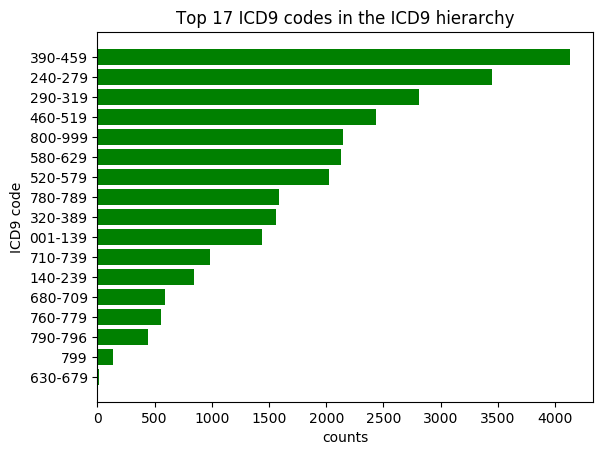

In [9]:
codes_counts =icd9_codes.items()
codes_counts.sort(key=itemgetter(1), reverse=True)
icd9_labels, values = zip(*codes_counts)
indexes = np.arange(len(icd9_labels))
plt.rcdefaults()
fig,ax = plt.subplots()
ax.barh(indexes, values,  align='center', color='green', ecolor='black')
ax.set_yticks(indexes)
ax.set_yticklabels(icd9_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('counts')
ax.set_ylabel('ICD9 code')
ax.set_title('Top ' + str(number_icd9_first_level) + ' ICD9 codes in the ICD9 hierarchy')
plt.show()

In [10]:
#preprocess icd9 codes to vectors 
top_codes = ICD9_FIRST_LEVEL
labels = vectorization.vectorize_icd_column(df, 'ICD9', top_codes)
print 'sample of vectorized icd9 labels: ', labels[0]


sample of vectorized icd9 labels:  [1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0]


## Pre process Notes

In [11]:
#preprocess notes
MAX_VOCAB = None # to limit original number of words (None if no limit)
MAX_SEQ_LENGTH = 5000 # to limit length of word sequence (None if no limit)
df.TEXT = vectorization.clean_notes(df, 'TEXT')
data_vectorized, dictionary, MAX_VOCAB = vectorization.vectorize_notes(df.TEXT, MAX_VOCAB, verbose = True)
data, MAX_SEQ_LENGTH = vectorization.pad_notes(data_vectorized, MAX_SEQ_LENGTH)

print("Final Vocabulary: %s" % MAX_VOCAB)
print("Final Max Sequence Length: %s" % MAX_SEQ_LENGTH)

Vocabulary size: 45144
Average note length: 1639.68899431
Max note length: 9684
Final Vocabulary: 45144
Final Max Sequence Length: 5000


In [12]:
EMBEDDING_DIM = 100 # given the glove that we chose
EMBEDDING_MATRIX= []

In [13]:
#creating glove embeddings
EMBEDDING_LOC = '../data/notes.100.txt' # location of embedding
EMBEDDING_MATRIX, embedding_dict = vectorization.embedding_matrix(EMBEDDING_LOC,
                                                                  dictionary, EMBEDDING_DIM, verbose = True, sigma=True)


('Vocabulary in notes:', 45144)
('Vocabulary in original embedding:', 21056)
('Vocabulary intersection:', 19967)


## Split Files

In [14]:
#split sets
X_train, X_val, X_test, y_train, y_val, y_test = helpers.train_val_test_split(
    data, labels, val_size=0.2, test_size=0.1, random_state=101)
print("Train: ", X_train.shape, y_train.shape)
print("Validation: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

('Train: ', (3688, 5000), (3688, 19))
('Validation: ', (1054, 5000), (1054, 19))
('Test: ', (528, 5000), (528, 19))


In [14]:
# Delete temporary variables to free some memory
del df, data, labels

## Super Basic Baseline with top 4
Always predict top 4

In [14]:
# finding out the top icd9 codes
top_4_icd9 = icd9_codes.most_common(4)
print "most common 4 icd9_codes: ", top_4_icd9
top_4_icd9_label = ' '.join(code for code,count in top_4_icd9 )
print 'label for the top 4 icd9 codes: ', top_4_icd9_label

most common 4 icd9_codes:  [('390-459', 4149), ('240-279', 3476), ('290-319', 2809), ('460-519', 2481)]
label for the top 4 icd9 codes:  390-459 240-279 290-319 460-519


In [15]:
#converting ICD9 prediction to a vector
top4_icd9_vector =  vectorization.vectorize_icd_string(top_4_icd9_label, ICD9_FIRST_LEVEL)
print ICD9_FIRST_LEVEL
print top4_icd9_vector

['001-139', '140-239', '240-279', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '760-779', '780-789', '790-796', '797', '798', '799', '800-999']
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
## assign icd9_prediction_vector to every discharge
train_y_hat_baseline = [top4_icd9_vector]* len (y_train)
dev_y_hat_baseline = [top4_icd9_vector]* len (y_val)

In [17]:
helpers.show_f1_score(y_train, train_y_hat_baseline, y_val, dev_y_hat_baseline)

F1 scores
threshold | training | dev  
0.020:      0.532      0.526
0.030:      0.532      0.526
0.040:      0.532      0.526
0.050:      0.532      0.526
0.055:      0.532      0.526
0.058:      0.532      0.526
0.060:      0.532      0.526
0.080:      0.532      0.526
0.100:      0.532      0.526
0.200:      0.532      0.526
0.300:      0.532      0.526
0.500:      0.532      0.526


## Basic LSTM 

In [24]:
reload(lstm_model)
#### build model
l_model = lstm_model.build_lstm_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5000)              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 5000, 100)         4517400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_9 (Dense)              (None, 19)                969       
Total params: 4,548,569
Trainable params: 4,548,569
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
l_model.fit(X_train, y_train, batch_size=50, epochs=5, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/5
3688/3688 [==============================] - 394s - loss: 0.4788 - acc: 0.7623 - val_loss: 0.4208 - val_acc: 0.7915

In [26]:
pred_train = l_model.predict(X_train, batch_size=100)
pred_dev = l_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.493      0.498
0.030:      0.511      0.516
0.040:      0.529      0.533
0.050:      0.540      0.542
0.055:      0.543      0.545
0.058:      0.545      0.547
0.060:      0.547      0.549
0.080:      0.557      0.557
0.100:      0.574      0.570
0.200:      0.625      0.616
0.300:      0.650      0.640
0.400:      0.657      0.640
0.500:      0.623      0.615
0.600:      0.516      0.520
0.700:      0.422      0.432


## LSTM with Attention

In [17]:
import icd9_lstm_att_model

In [23]:
reload(icd9_lstm_att_model)
#### build model
latt_model = icd9_lstm_att_model.build_lstm_att_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = True, embedding_trainable =True,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,                             
                             num_classes=N_TOP )

attention_util.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, use_bias=False)`
  att = TimeDistributed(Dense(1, bias=False))(u_it)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
Embeddng (Embedding)             (None, 5000, 100)     4514500     input_5[0][0]                    
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 5000, 50)      30200       Embeddng[0][0]                   
____________________________________________________________________________________________________
time_distributed_7 (TimeDistribu (None, 5000, 50)      2550        lstm_4[0][0]                     
___________________________________________________________________________________________

attention_util.py:29: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  s_i =merge([att, inputs], mode='dot', dot_axes=(1,1), name='s_i dot')


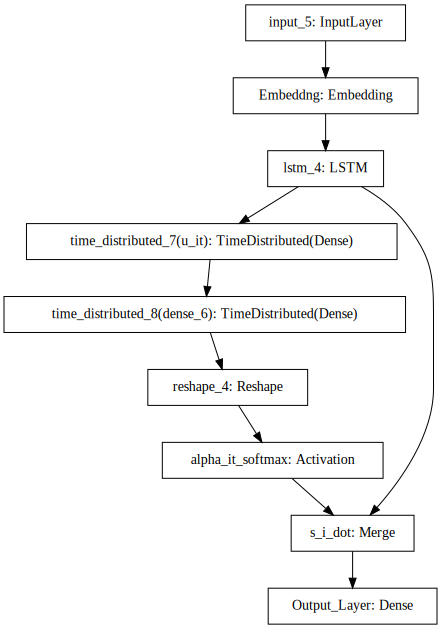

In [24]:
SVG(model_to_dot(latt_model).create(prog='dot', format='svg'))

In [21]:
model_lst_att_fit = latt_model.fit(X_train, y_train, batch_size=50, epochs=1, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/1
3688/3688 [==============================] - 421s - loss: 0.4856 - acc: 0.7608 - val_loss: 0.4404 - val_acc: 0.7807

In [22]:
model_lst_att_fit = latt_model.fit(X_train, y_train, batch_size=50, epochs=4, validation_data=(X_val, y_val), verbose=1)

Train on 3688 samples, validate on 1054 samples
Epoch 1/4
3688/3688 [==============================] - 421s - loss: 0.4390 - acc: 0.7836 - val_loss: 0.4302 - val_acc: 0.7880

 ```
 634s - loss: 0.5274 - acc: 0.7501 - val_loss: 0.4502 - val_acc: 0.7721
 2124s - loss: 0.5152 - acc: 0.7538 - val_loss: 0.4441 - val_acc: 0.7751
 1211s - loss: 0.4786 - acc: 0.7637 - val_loss: 0.4411 - val_acc: 0.7804
 ```

In [23]:
pred_train = latt_model.predict(X_train, batch_size=100)
pred_dev = latt_model.predict(X_val, batch_size=100)
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.504      0.509
0.030:      0.514      0.519
0.040:      0.524      0.529
0.050:      0.532      0.537
0.055:      0.536      0.540
0.058:      0.539      0.543
0.060:      0.541      0.545
0.080:      0.559      0.562
0.100:      0.573      0.575
0.200:      0.640      0.639
0.300:      0.672      0.664
0.400:      0.668      0.663
0.500:      0.622      0.615
0.600:      0.543      0.545
0.700:      0.450      0.452


In [52]:
latt_model.save('models/latt_model_5_epochs_5k.h5')

## CNN for text classification

Based on the following papers and links:
* "Convolutional Neural Networks for Sentence Classification"   
* "A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification"
* http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/
* https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras/blob/master/sentiment_cnn.py
* http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
* https://github.com/dennybritz/cnn-text-classification-tf/blob/master/text_cnn.py

In [15]:
reload(icd9_cnn_model)
#### build model
model = icd9_cnn_model.build_icd9_cnn_model (input_seq_length=MAX_SEQ_LENGTH, max_vocab = MAX_VOCAB,
                             external_embeddings = False,
                             embedding_dim=EMBEDDING_DIM,embedding_matrix=EMBEDDING_MATRIX,
                             num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5,
                             num_classes=N_TOP )

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 5000, 100)     4514500     input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 4999, 100)     20100       embedding[0][0]                  
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 4998, 100)     30100       embedding[0][0]                  
___________________________________________________________________________________________

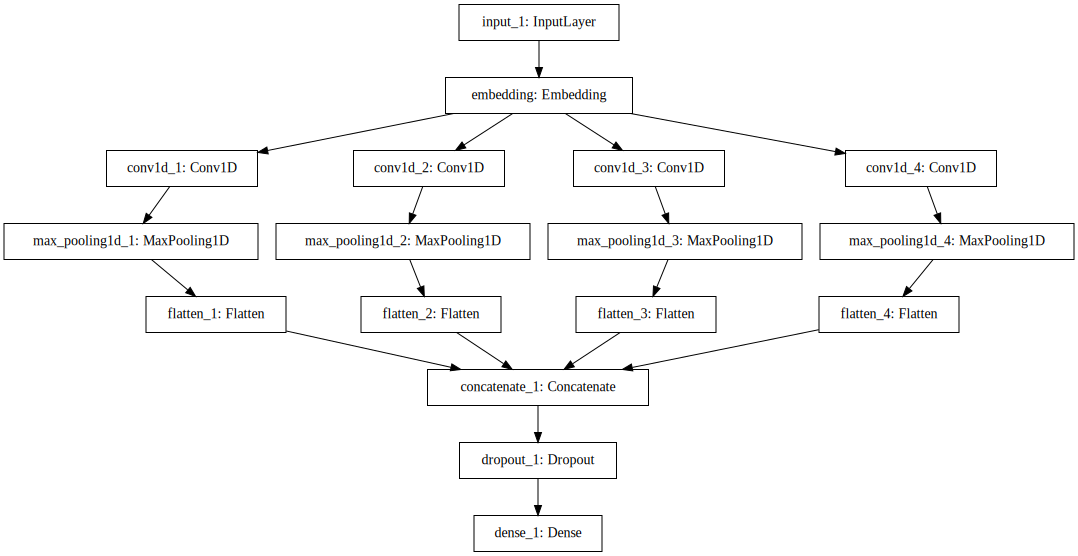

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
# Train the model
model.fit(X_train, y_train, batch_size=50, epochs=20, validation_data=(X_val, y_val), verbose=2)

Train on 3688 samples, validate on 1054 samples
Epoch 1/20
102s - loss: 0.3680 - acc: 0.8344 - val_loss: 0.3533 - val_acc: 0.8430
Epoch 2/20
103s - loss: 0.3595 - acc: 0.8408 - val_loss: 0.3467 - val_acc: 0.8470
Epoch 3/20
103s - loss: 0.3508 - acc: 0.8456 - val_loss: 0.3412 - val_acc: 0.8526
Epoch 4/20
103s - loss: 0.3456 - acc: 0.8523 - val_loss: 0.3353 - val_acc: 0.8578
Epoch 5/20
103s - loss: 0.3370 - acc: 0.8575 - val_loss: 0.3325 - val_acc: 0.8587
Epoch 6/20
103s - loss: 0.3325 - acc: 0.8600 - val_loss: 0.3275 - val_acc: 0.8626
Epoch 7/20
103s - loss: 0.3270 - acc: 0.8638 - val_loss: 0.3266 - val_acc: 0.8646
Epoch 8/20
102s - loss: 0.3227 - acc: 0.8669 - val_loss: 0.3246 - val_acc: 0.8668
Epoch 9/20
102s - loss: 0.3173 - acc: 0.8699 - val_loss: 0.3231 - val_acc: 0.8689
Epoch 10/20
102s - loss: 0.3118 - acc: 0.8728 - val_loss: 0.3216 - val_acc: 0.8702
Epoch 11/20
102s - loss: 0.3080 - acc: 0.8752 - val_loss: 0.3191 - val_acc: 0.8712
Epoch 12/20
102s - loss: 0.3029 - acc: 0.8802 - 

In [30]:
pred_train = model.predict(X_train, batch_size=50)
pred_dev = model.predict(X_val, batch_size=50)
# perform evaluation
helpers.show_f1_score(y_train, pred_train, y_val, pred_dev)

F1 scores
threshold | training | dev  
0.020:      0.546      0.534
0.030:      0.569      0.555
0.040:      0.590      0.574
0.050:      0.611      0.591
0.055:      0.620      0.599
0.058:      0.627      0.604
0.060:      0.631      0.607
0.080:      0.664      0.632
0.100:      0.692      0.652
0.200:      0.792      0.724
0.300:      0.849      0.756
0.400:      0.868      0.762
0.500:      0.861      0.753
0.600:      0.838      0.741
0.700:      0.797      0.710


In [54]:
model.save('models/cnn_20_epochs.h5')
#model = load_model('models/cnn_20_epochs.h5')


### only internal embedding
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
97s - loss: 0.6287 - acc: 0.7253 - val_loss: 0.4606 - val_acc: 0.7848
Epoch 2/5
97s - loss: 0.4759 - acc: 0.7693 - val_loss: 0.4380 - val_acc: 0.7949
Epoch 3/5
97s - loss: 0.4539 - acc: 0.7793 - val_loss: 0.4202 - val_acc: 0.8004
Epoch 4/5
97s - loss: 0.4379 - acc: 0.7876 - val_loss: 0.4057 - val_acc: 0.8158
Epoch 5/5
97s - loss: 0.4260 - acc: 0.7974 - val_loss: 0.3929 - val_acc: 0.8216

F1 scores
threshold | training | dev  
0.020:      0.500      0.492
0.030:      0.514      0.505
0.040:      0.526      0.516
0.050:      0.535      0.525
0.055:      0.539      0.529
0.058:      0.541      0.532
0.060:      0.542      0.533
0.080:      0.558      0.547
0.100:      0.573      0.562
0.200:      0.637      0.627
0.300:      0.662      0.655
0.400:      0.664      0.660
0.500:      0.594      0.601
0.600:      0.536      0.548
0.700:      0.413      0.418

```




### with notes embeddings file (trained will all MIMIC notes)

```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
98s - loss: 1.3827 - acc: 0.6921 - val_loss: 0.5128 - val_acc: 0.7887
Epoch 2/5
98s - loss: 0.7755 - acc: 0.7243 - val_loss: 0.4364 - val_acc: 0.7984
Epoch 3/5
98s - loss: 0.6013 - acc: 0.7398 - val_loss: 0.4202 - val_acc: 0.8069
Epoch 4/5
98s - loss: 0.5253 - acc: 0.7559 - val_loss: 0.4100 - val_acc: 0.8109
Epoch 5/5
99s - loss: 0.4852 - acc: 0.7706 - val_loss: 0.4018 - val_acc: 0.8123

F1 scores
threshold | training | dev  
0.020:      0.513      0.506
0.030:      0.526      0.516
0.040:      0.536      0.527
0.050:      0.544      0.534
0.055:      0.548      0.537
0.058:      0.550      0.539
0.060:      0.552      0.541
0.080:      0.566      0.556
0.100:      0.581      0.568
0.200:      0.635      0.621
0.300:      0.665      0.646
0.400:      0.676      0.652
0.500:      0.623      0.600
0.600:      0.514      0.505
0.700:      0.416      0.420

```
### Using pre-trained Wiki Glove embedding plus internal embedding
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
105s - loss: 1.1842 - acc: 0.6948 - val_loss: 0.4606 - val_acc: 0.7826
Epoch 2/5
105s - loss: 0.6159 - acc: 0.7321 - val_loss: 0.4323 - val_acc: 0.7908
Epoch 3/5
105s - loss: 0.5112 - acc: 0.7545 - val_loss: 0.4246 - val_acc: 0.7979
Epoch 4/5
104s - loss: 0.4742 - acc: 0.7721 - val_loss: 0.4157 - val_acc: 0.8007
Epoch 5/5
104s - loss: 0.4521 - acc: 0.7795 - val_loss: 0.4084 - val_acc: 0.8014

F1 scores

threshold | training | dev  
0.020:      0.488      0.486
0.030:      0.501      0.498
0.040:      0.513      0.509
0.050:      0.522      0.519
0.055:      0.527      0.524
0.058:      0.530      0.527
0.060:      0.532      0.529
0.080:      0.550      0.546
0.100:      0.566      0.562
0.200:      0.623      0.617
0.300:      0.660      0.641
0.400:      0.660      0.627
0.500:      0.569      0.543
0.600:      0.468      0.459
0.700:      0.391      0.379
```


### Using wiki glove 300
```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
289s - loss: 1.1223 - acc: 0.6978 - val_loss: 0.4560 - val_acc: 0.7884
Epoch 2/5
286s - loss: 0.6181 - acc: 0.7385 - val_loss: 0.4200 - val_acc: 0.7989
Epoch 3/5
287s - loss: 0.5019 - acc: 0.7605 - val_loss: 0.4113 - val_acc: 0.8030
Epoch 4/5
286s - loss: 0.4624 - acc: 0.7772 - val_loss: 0.4040 - val_acc: 0.8084
Epoch 5/5
290s - loss: 0.4376 - acc: 0.7886 - val_loss: 0.3990 - val_acc: 0.8091

F1 scores
threshold | training | dev  
0.020:      0.488      0.486
0.030:      0.501      0.498
0.040:      0.513      0.509
0.050:      0.522      0.519
0.055:      0.527      0.524
0.058:      0.530      0.527
0.060:      0.532      0.529
0.080:      0.550      0.546
0.100:      0.566      0.562
0.200:      0.623      0.617
0.300:      0.660      0.641
0.400:      0.660      0.627
0.500:      0.569      0.543
0.600:      0.468      0.459
0.700:      0.391      0.379

```

## Dropout =0.5 , internal embeddings

```
Train on 3688 samples, validate on 1054 samples
Epoch 1/5
103s - loss: 0.5728 - acc: 0.7669 - val_loss: 0.4375 - val_acc: 0.7938
Epoch 2/5
102s - loss: 0.4283 - acc: 0.7935 - val_loss: 0.3976 - val_acc: 0.8152
Epoch 3/5
103s - loss: 0.4001 - acc: 0.8101 - val_loss: 0.3801 - val_acc: 0.8245
Epoch 4/5
103s - loss: 0.3885 - acc: 0.8196 - val_loss: 0.3721 - val_acc: 0.8289
Epoch 5/5
103s - loss: 0.3775 - acc: 0.8264 - val_loss: 0.3604 - val_acc: 0.8383

F1 scores
threshold | training | dev  
0.020:      0.517      0.508
0.030:      0.532      0.524
0.040:      0.545      0.537
0.050:      0.556      0.547
0.055:      0.561      0.553
0.058:      0.565      0.556
0.060:      0.567      0.558
0.080:      0.591      0.582
0.100:      0.610      0.599
0.200:      0.672      0.660
0.300:      0.703      0.691
0.400:      0.705      0.691
0.500:      0.673      0.664
0.600:      0.612      0.608
0.700:      0.523      0.526


Train on 3688 samples, validate on 1054 samples
Epoch 1/20
102s - loss: 0.3680 - acc: 0.8344 - val_loss: 0.3533 - val_acc: 0.8430
Epoch 2/20
103s - loss: 0.3595 - acc: 0.8408 - val_loss: 0.3467 - val_acc: 0.8470
Epoch 3/20
103s - loss: 0.3508 - acc: 0.8456 - val_loss: 0.3412 - val_acc: 0.8526
Epoch 4/20
103s - loss: 0.3456 - acc: 0.8523 - val_loss: 0.3353 - val_acc: 0.8578
Epoch 5/20
103s - loss: 0.3370 - acc: 0.8575 - val_loss: 0.3325 - val_acc: 0.8587
Epoch 6/20
103s - loss: 0.3325 - acc: 0.8600 - val_loss: 0.3275 - val_acc: 0.8626
Epoch 7/20
103s - loss: 0.3270 - acc: 0.8638 - val_loss: 0.3266 - val_acc: 0.8646
Epoch 8/20
102s - loss: 0.3227 - acc: 0.8669 - val_loss: 0.3246 - val_acc: 0.8668
Epoch 9/20
102s - loss: 0.3173 - acc: 0.8699 - val_loss: 0.3231 - val_acc: 0.8689
Epoch 10/20
102s - loss: 0.3118 - acc: 0.8728 - val_loss: 0.3216 - val_acc: 0.8702
Epoch 11/20
102s - loss: 0.3080 - acc: 0.8752 - val_loss: 0.3191 - val_acc: 0.8712
Epoch 12/20
102s - loss: 0.3029 - acc: 0.8802 - val_loss: 0.3198 - val_acc: 0.8716
Epoch 13/20
102s - loss: 0.2971 - acc: 0.8828 - val_loss: 0.3184 - val_acc: 0.8733
Epoch 14/20
103s - loss: 0.2926 - acc: 0.8876 - val_loss: 0.3190 - val_acc: 0.8731
Epoch 15/20
102s - loss: 0.2891 - acc: 0.8897 - val_loss: 0.3209 - val_acc: 0.8737
Epoch 16/20
102s - loss: 0.2849 - acc: 0.8920 - val_loss: 0.3200 - val_acc: 0.8736
Epoch 17/20
102s - loss: 0.2799 - acc: 0.8955 - val_loss: 0.3221 - val_acc: 0.8744
Epoch 18/20
102s - loss: 0.2742 - acc: 0.8990 - val_loss: 0.3223 - val_acc: 0.8749
Epoch 19/20
102s - loss: 0.2713 - acc: 0.9015 - val_loss: 0.3250 - val_acc: 0.8750
Epoch 20/20
100s - loss: 0.2665 - acc: 0.9035 - val_loss: 0.3264 - val_acc: 0.8742

F1 scores
threshold | training | dev  
0.020:      0.546      0.534
0.030:      0.569      0.555
0.040:      0.590      0.574
0.050:      0.611      0.591
0.055:      0.620      0.599
0.058:      0.627      0.604
0.060:      0.631      0.607
0.080:      0.664      0.632
0.100:      0.692      0.652
0.200:      0.792      0.724
0.300:      0.849      0.756
0.400:      0.868      0.762
0.500:      0.861      0.753
0.600:      0.838      0.741
0.700:      0.797      0.710

```

## Notes:


(1) There is a LSTM model by this paper: "Applying Deep Learning to ICD-9 Multi-label Classification from Medical Records" which did achieve a 42% F1-score. (https://cs224d.stanford.edu/reports/priyanka.pdf), but it only uses the top 10 icd9 codes. We are getting 46% (just running with 1000 notes so far)


(2) The "A Comparison of Rule-Based and Deep Learning Models for Patient Phenotyping"  study did get a 70% F1-score, but they don't use the icd9-labels but phenotypes labels they annotated themselved (via a group of medical professionals). (https://arxiv.org/abs/1703.08705). There were ONLY 10 phenotypes.

The discharge summaries are labeled with ICD9-codes that are leaves in the ICD9-hierarchy (which has hundreds of ICD9-codes), then maybe these leave nodes are too specific and difficult to predict, one experiment would be to replaced all the ICD9-codes with their parent in the second or third level in the hierarchy and see if predictions work better that way.   

(3) our baseline with top 20 codes had a f1-score of 35% (assigning top 4 icd9 codes to all notes, using a CNN with no external embeddings is getting about 40% f1-score.. a little better than the baseline

(4) Papers published and best practices report  that external embeddings improve considerable the model's performance.. maybe it is not the case here because of the medical terms..   

(5) Fixed Thresholding doesn't work well for multilabel classifications, we can implement a model to choose the appropriate threshold for each record (see notes above)

(6) for loss function: binary and categorical cross entropy gave same results

In [21]:
model_hh = load_model('models/cnn_20_epochs.h5')